In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib as mpl

mpl.rcParams['font.size']=16

Time = 0, max error = 1.1663902973338325, min error = 1.0450189195030013, mean error = 1.14932388242575
Time = 5, max error = 11.818709337356388, min error = 0.0, mean error = 1.398787998686229
Time = 8, max error = 8.80560734070171, min error = 0.0, mean error = 0.4777853829642982
Time = 15, max error = 9.47666227693506, min error = 7.096662681646493e-07, mean error = 0.5469024580854149


/tmp/ipykernel_5626/545209472.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


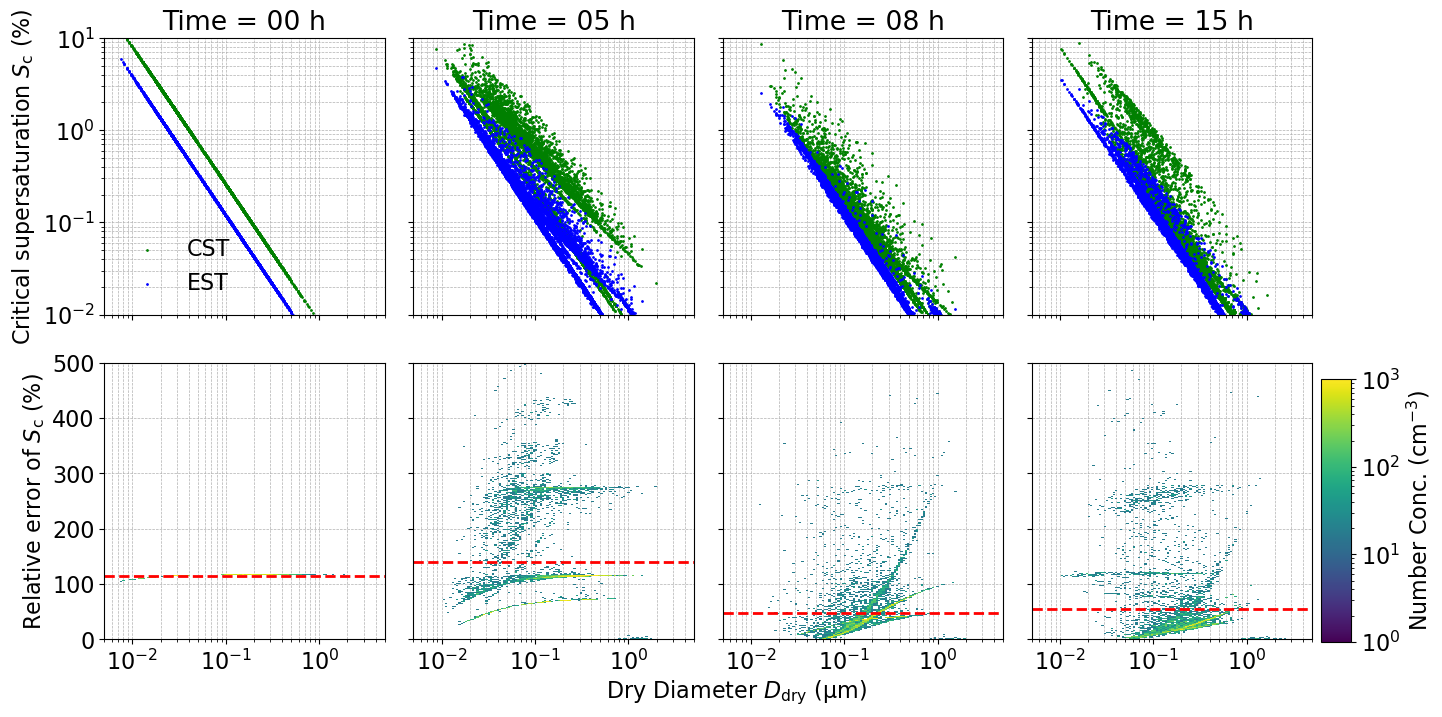

In [3]:
times = [1, 6, 9, 16]


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7.5), sharex='col', sharey='row')

for i, time in enumerate(times):
    file_path = f'/data/keeling/a/xx24/d/proj_film/partmc/scenarios/1_urban_plume/out/single_particle_000000{time:02d}.csv'
    try:
        file = pd.read_csv(file_path, sep='\s+', header=None).set_index(0).T
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
        continue
    file.reset_index(drop=True, inplace=True)


    d_dry = file['dry_diameters']
    scs = file['crit_rhs'] - 1
    scs_varying_sigma = file['crit_rhs_varying_sigma'] - 1
    num_conc = file['num_con']
    scs_err = (scs - scs_varying_sigma) / scs_varying_sigma
    print(f"Time = {time-1}, max error = {scs_err.max()}, min error = {scs_err.min()}, mean error = {scs_err.mean()}")

    binx = np.logspace(-3, 3, 250)  
    biny = np.linspace(0, 500, 500) 

    # 使用 scipy 的 binned_statistic_2d 进行分箱统计
    nc, xedges, yedges, binnumber = stats.binned_statistic_2d(
        d_dry * 1e6,               
        scs_err * 100,             
        values=num_conc,
        statistic='count',
        bins=[binx, biny]
    )

    XX, YY = np.meshgrid(xedges, yedges)
    nc = nc / (np.log(binx[1] / binx[0]) * (biny[1] - biny[0]))

    ax_scatter = axes[0, i]
    ax_scatter.scatter(d_dry * 1e6, scs * 100, s=1, c='g', label='CST')
    ax_scatter.scatter(d_dry * 1e6, scs_varying_sigma * 100, s=1, c='b', label='EST')
    ax_scatter.set_yscale('log')
    ax_scatter.set_xlim(5e-3, 5e0)
    ax_scatter.set_ylim(1e-2, 1e1)
    ax_scatter.set_axisbelow(True)
    ax_scatter.grid(True, which="both", ls="--", linewidth=0.5)
    if i == 0:
        ax_scatter.set_ylabel(r"Critical supersaturation $S_{\rm c}$ (%)")
        ax_scatter.legend(loc='lower left', frameon=False)
    ax_scatter.set_title(f'Time = {int(time-1) :02d} h',loc='center')

    # if i == 1:
    #     ax_scatter.set_xlabel(r"Dry Diameter $D_{\rm dry}$ ($\rm \mu m$)")
    # elif i == 0:
    #     ax_scatter.set_xlabel(r"Dry Diameter $D_{\rm dry}$ ($\rm \mu m$)")

    ax_pcolormesh = axes[1, i]
    pcm = ax_pcolormesh.pcolormesh(
        XX, YY, nc.T,
        norm=colors.LogNorm(vmin=1e0, vmax=1e3),
        cmap='viridis',
        shading='auto',
        # edgecolor='face'
    )
    ax_pcolormesh.set_xscale('log')
    ax_pcolormesh.set_xlim(5e-3, 5e0)
    ax_pcolormesh.set_ylim(0, 500)
    ax_pcolormesh.set_axisbelow(True)
    ax_pcolormesh.grid(True, which="both", ls="--", linewidth=0.5)
    ax_pcolormesh.axhline(y = 100 * scs_err.mean(), ls='--', c='r', linewidth=2)  
    if i == 0:
        ax_pcolormesh.set_ylabel(r"Relative error of $S_{\rm c}$ (%)")

fig.text(0.5, 0, r"Dry Diameter $D_{\rm dry}$ ($\rm \mu m$)", ha='center')


cbar_ax = fig.add_axes([0.89, 0.075, 0.02, 0.35])  # [left, bottom, width, height]
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label(r"Number Conc. ($\rm cm^{-3}$)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('/data/keeling/a/xx24/d/proj_film/scs_compare.pdf', bbox_inches='tight', dpi=300)